# Project 2: Binary Classification with PyTorch

Building a binary classifier to predict breast cancer diagnosis (malignant vs benign) using the Wisconsin Breast Cancer dataset.

**Concepts Covered:**
- Binary classification vs regression
- Sigmoid activation function
- Binary Cross Entropy Loss (`BCELoss`)
- Feature scaling with `StandardScaler`
- Classification metrics: precision, recall, F1-score
- Confusion matrix interpretation
- Threshold tuning for medical diagnosis
- Multi-layer feedforward neural network

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
CUDA available: False


---
## Phase 1: Understanding the Difference

| Aspect | Regression (Project 1) | Classification (Project 2) |
|---|---|---|
| Output | Continuous (price, score) | Category (yes/no, 0/1) |
| Final activation | None | Sigmoid (squashes to 0-1) |
| Loss function | MSELoss | BCELoss |
| Metrics | MSE, MAE, R² | Accuracy, Precision, Recall, F1 |

---
## Phase 2: Load and Prepare Real Data

In [47]:
# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

print(f"Features: {X.shape[1]} (e.g., {list(data.feature_names[:5])})")
print(f"Samples: {X.shape[0]}")
print(f"Classes: {np.unique(y)} → 0: Malignant, 1: Benign")
print(f"Class distribution: Malignant={sum(y==0)}, Benign={sum(y==1)}")

Features: 30 (e.g., [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness')])
Samples: 569
Classes: [0 1] → 0: Malignant, 1: Benign
Class distribution: Malignant=212, Benign=357


In [48]:
# Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling — CRITICAL for neural networks
# fit_transform on train, only transform on test (prevents data leakage)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: torch.Size([455, 30]), Test: torch.Size([114, 30])


---
## Phase 2: Build and Train the Model

In [49]:
# Define binary classification model
class BinaryClassifier(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.layer1 = nn.Linear(input_features, 16)
        self.layer2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))  # squashes output to 0-1 probability
        return x

model = BinaryClassifier(input_features=30)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

BinaryClassifier(
  (layer1): Linear(in_features=30, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 641


In [50]:
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with accuracy tracking
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(200):
    # --- Training ---
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Calculate training accuracy
    with torch.no_grad():
        train_predicted = (y_pred >= 0.5).float()  # threshold at 0.5
        train_acc = (train_predicted == y_train).float().mean()
    
    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = criterion(y_test_pred, y_test)
        test_predicted = (y_test_pred >= 0.5).float()
        test_acc = (test_predicted == y_test).float().mean()
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_acc.item())
    test_accuracies.append(test_acc.item())
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.4f}")

Epoch   0 | Train Loss: 0.6739 | Test Loss: 0.6680 | Train Acc: 0.6286 | Test Acc: 0.6140
Epoch  20 | Train Loss: 0.5694 | Test Loss: 0.5608 | Train Acc: 0.7912 | Test Acc: 0.8070
Epoch  40 | Train Loss: 0.4554 | Test Loss: 0.4411 | Train Acc: 0.9033 | Test Acc: 0.9123
Epoch  60 | Train Loss: 0.3590 | Test Loss: 0.3366 | Train Acc: 0.9341 | Test Acc: 0.9825
Epoch  80 | Train Loss: 0.2865 | Test Loss: 0.2597 | Train Acc: 0.9407 | Test Acc: 0.9737
Epoch 100 | Train Loss: 0.2284 | Test Loss: 0.2027 | Train Acc: 0.9538 | Test Acc: 0.9737
Epoch 120 | Train Loss: 0.1822 | Test Loss: 0.1610 | Train Acc: 0.9626 | Test Acc: 0.9737
Epoch 140 | Train Loss: 0.1479 | Test Loss: 0.1321 | Train Acc: 0.9692 | Test Acc: 0.9825
Epoch 160 | Train Loss: 0.1231 | Test Loss: 0.1117 | Train Acc: 0.9736 | Test Acc: 0.9825
Epoch 180 | Train Loss: 0.1057 | Test Loss: 0.0977 | Train Acc: 0.9802 | Test Acc: 0.9912

Final Test Accuracy: 0.9912


---
## Phase 3: Detailed Evaluation

In [51]:
# Classification metrics
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_labels = (y_test_pred >= 0.5).float()

# Convert to numpy for sklearn
y_true_np = y_test.numpy()
y_pred_np = y_test_labels.numpy()

print("Classification Report:")
print(classification_report(y_true_np, y_pred_np, target_names=["Malignant", "Benign"]))

print("Confusion Matrix:")
cm = confusion_matrix(y_true_np, y_pred_np)
print(cm)

Classification Report:
              precision    recall  f1-score   support

   Malignant       1.00      0.98      0.99        43
      Benign       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Confusion Matrix:
[[42  1]
 [ 0 71]]


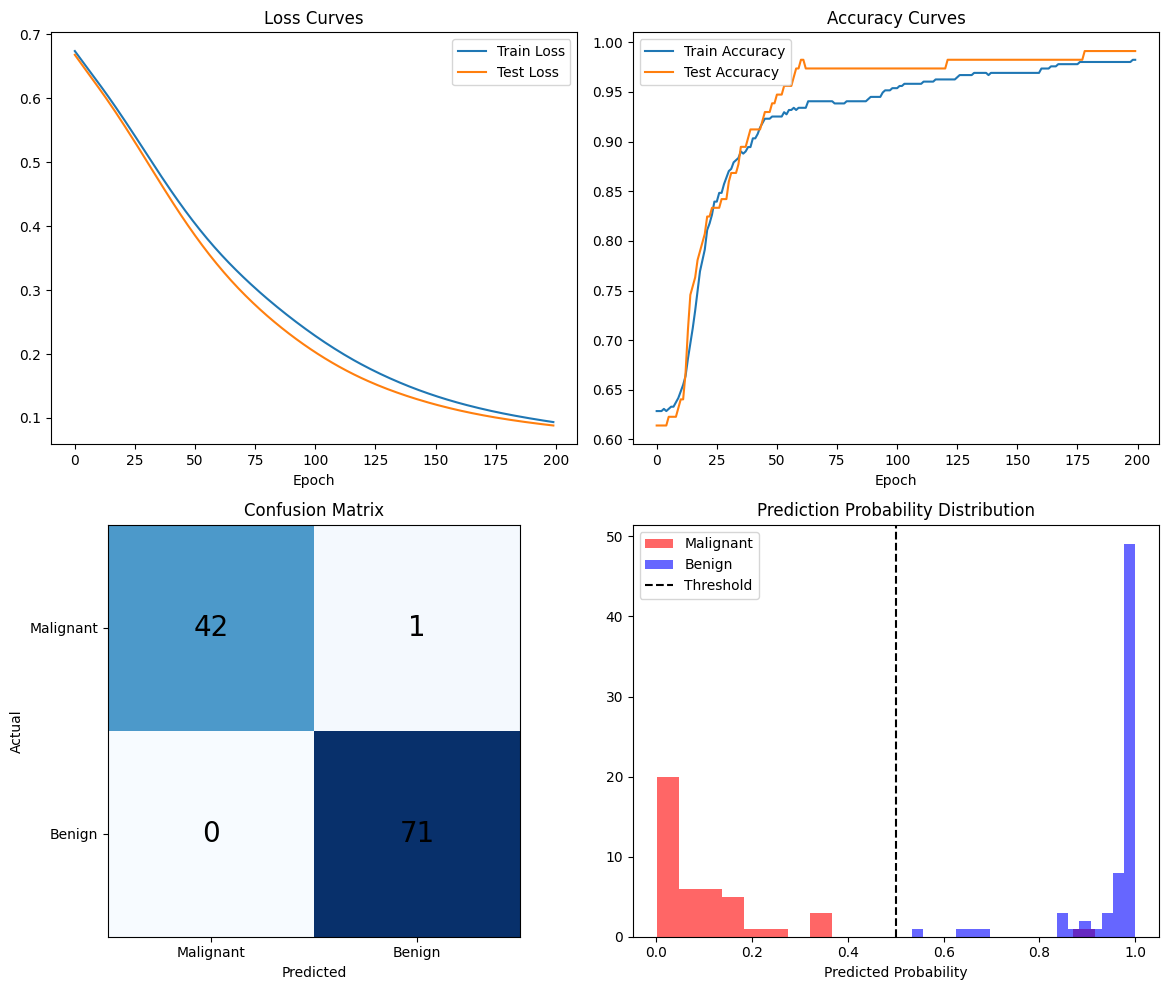

In [52]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loss curves
axes[0][0].plot(train_losses, label="Train Loss")
axes[0][0].plot(test_losses, label="Test Loss")
axes[0][0].set_title("Loss Curves")
axes[0][0].set_xlabel("Epoch")
axes[0][0].legend()

# Accuracy curves
axes[0][1].plot(train_accuracies, label="Train Accuracy")
axes[0][1].plot(test_accuracies, label="Test Accuracy")
axes[0][1].set_title("Accuracy Curves")
axes[0][1].set_xlabel("Epoch")
axes[0][1].legend()

# Confusion matrix heatmap
im = axes[1][0].imshow(cm, cmap="Blues")
axes[1][0].set_xticks([0, 1])
axes[1][0].set_yticks([0, 1])
axes[1][0].set_xticklabels(["Malignant", "Benign"])
axes[1][0].set_yticklabels(["Malignant", "Benign"])
axes[1][0].set_xlabel("Predicted")
axes[1][0].set_ylabel("Actual")
axes[1][0].set_title("Confusion Matrix")
for i in range(2):
    for j in range(2):
        axes[1][0].text(j, i, cm[i][j], ha="center", va="center", fontsize=20)

# Prediction probability distribution
axes[1][1].hist(y_test_pred[y_test == 0].numpy(), bins=20, alpha=0.6, label="Malignant", color="red")
axes[1][1].hist(y_test_pred[y_test == 1].numpy(), bins=20, alpha=0.6, label="Benign", color="blue")
axes[1][1].axvline(x=0.5, color="black", linestyle="--", label="Threshold")
axes[1][1].set_title("Prediction Probability Distribution")
axes[1][1].set_xlabel("Predicted Probability")
axes[1][1].legend()

plt.tight_layout()
plt.show()

---
## Experiment: Threshold Tuning for Medical Diagnosis

In cancer diagnosis, missing a malignant case (false negative) is far worse than a false alarm (false positive). Lowering the threshold makes the model more aggressive in flagging malignant cases.

In [53]:
# Compare different thresholds
thresholds = [0.3, 0.5, 0.7]

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)

for t in thresholds:
    y_labels = (y_test_pred >= t).float().numpy()
    print(f"\n--- Threshold: {t} ---")
    print(classification_report(y_true_np, y_labels, target_names=["Malignant", "Benign"]))


--- Threshold: 0.3 ---
              precision    recall  f1-score   support

   Malignant       1.00      0.91      0.95        43
      Benign       0.95      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114


--- Threshold: 0.5 ---
              precision    recall  f1-score   support

   Malignant       1.00      0.98      0.99        43
      Benign       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114


--- Threshold: 0.7 ---
              precision    recall  f1-score   support

   Malignant       0.91      0.98      0.94        43
      Benign       0.99      0.94      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
we

---
## Experiment: Impact of Feature Scaling

Demonstrating why `StandardScaler` is critical for neural networks.

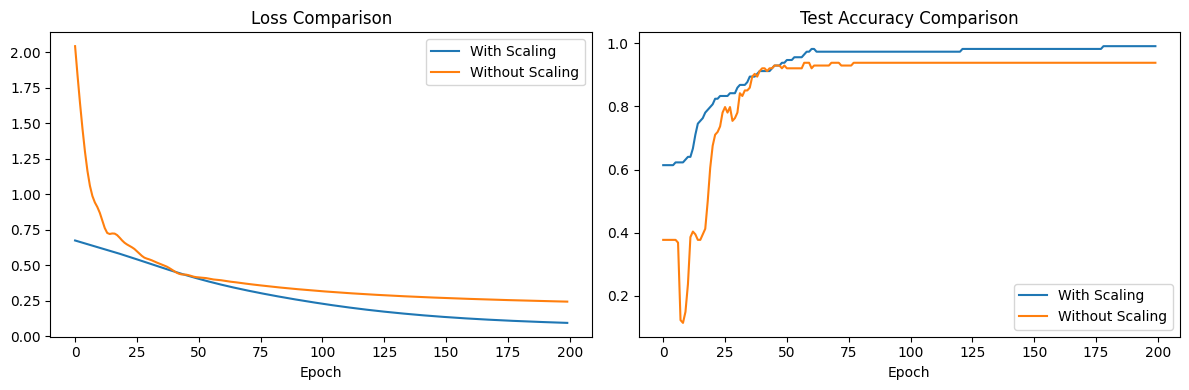

Final Accuracy WITH scaling: 0.9912
Final Accuracy WITHOUT scaling: 0.9386


In [54]:
# Reload data WITHOUT scaling
data = load_breast_cancer()
X_raw, y_raw = data.data, data.target
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

X_train_raw = torch.tensor(X_train_raw, dtype=torch.float32)
X_test_raw = torch.tensor(X_test_raw, dtype=torch.float32)
y_train_raw = torch.tensor(y_train_raw, dtype=torch.float32).reshape(-1, 1)
y_test_raw = torch.tensor(y_test_raw, dtype=torch.float32).reshape(-1, 1)

# Train same model without scaling
model_noscale = BinaryClassifier(input_features=30)
criterion_ns = nn.BCELoss()
optimizer_ns = optim.Adam(model_noscale.parameters(), lr=0.001)

noscale_losses = []
noscale_accuracies = []

for epoch in range(200):
    model_noscale.train()
    y_pred = model_noscale(X_train_raw)
    loss = criterion_ns(y_pred, y_train_raw)
    
    optimizer_ns.zero_grad()
    loss.backward()
    optimizer_ns.step()
    
    model_noscale.eval()
    with torch.no_grad():
        y_test_pred_ns = model_noscale(X_test_raw)
        test_predicted_ns = (y_test_pred_ns >= 0.5).float()
        test_acc_ns = (test_predicted_ns == y_test_raw).float().mean()
    
    noscale_losses.append(loss.item())
    noscale_accuracies.append(test_acc_ns.item())

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label="With Scaling")
axes[0].plot(noscale_losses, label="Without Scaling")
axes[0].set_title("Loss Comparison")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(test_accuracies, label="With Scaling")
axes[1].plot(noscale_accuracies, label="Without Scaling")
axes[1].set_title("Test Accuracy Comparison")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Final Accuracy WITH scaling: {test_accuracies[-1]:.4f}")
print(f"Final Accuracy WITHOUT scaling: {noscale_accuracies[-1]:.4f}")

In [55]:
# Save model
torch.save(model.state_dict(), "binary_classifier.pth")
print("Model saved!")

Model saved!


---
## Key Takeaways

### Concepts Learned
1. **Sigmoid** — squashes output to 0-1 probability for binary classification
2. **BCELoss** — Binary Cross Entropy, penalizes confident wrong predictions heavily
3. **StandardScaler** — normalizes features for stable training; `fit_transform` on train, `transform` on test
4. **Threshold** — converts probability to class label; default 0.5, can be tuned based on use case
5. **Precision** — of all positive predictions, how many were correct
6. **Recall** — of all actual positives, how many did the model catch
7. **F1-Score** — harmonic mean of precision and recall
8. **Confusion Matrix** — visualizes TP, TN, FP, FN

### Test your Knowledge
- Difference between regression and classification
- Why sigmoid is used for binary classification
- BCELoss vs MSELoss — when to use which
- Why feature scaling matters for neural networks
- Precision vs recall trade-off (especially in medical diagnosis)
- Data leakage prevention (`fit_transform` vs `transform`)
- Impact of model capacity (number of neurons) on performance